In [1]:
!pip install tensorflow numpy pillow

In [11]:
import os

tflite_model_path =r'C:\Users\vishn\Desktop\mini project\dog_skin_disease_densenet121_finetuned_model.tflite'

if os.path.exists(tflite_model_path):
    print("✅ File found!")
else:
    print("❌ File not found! Check the file name and path.")


✅ File found!


In [10]:
import tensorflow as tf
import numpy as np
from PIL import Image

tflite_model_path = r'C:\Users\vishn\Desktop\mini project\dog_skin_disease_densenet121_finetuned_model.tflite'  # Update with the correct file name
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input Shape:", input_details[0]['shape'])
print("Output Shape:", output_details[0]['shape'])


Input Shape: [  1 224 224   3]
Output Shape: [1 4]


In [12]:
def preprocess_image(image_path):
    img = Image.open(image_path).convert("RGB")  
    img = img.resize((224, 224))  
    img_array = np.array(img, dtype=np.float32) / 255.0  
    img_array = np.expand_dims(img_array, axis=0)  
    return img_array


In [14]:
def predict(image_path):
    image = preprocess_image(image_path)
    
    interpreter.set_tensor(input_details[0]['index'], image)
    
    interpreter.invoke()
    
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    class_labels = ['Bacterial_dermatosis', 'Fungal_infections', 'Healthy', 'Hypersensitivity_allergic_dermatosis']  
    predicted_class = np.argmax(output_data)  
    confidence = np.max(output_data)  
    
    return class_labels[predicted_class], confidence

#image_path = r"C:\Users\vishn\Downloads\hyper.jpg"
#image_path = r"C:\Users\vishn\Downloads\healthy.jpg"
#image_path = r"C:\Users\vishn\Downloads\fung.jpeg"
#image_path = r"C:\Users\vishn\Downloads\bac.jpg"
image_path = r"C:\Users\vishn\Downloads\WhatsApp Image 2025-03-05 at 22.57.03_8f270bc6.jpg"

predicted_label, confidence_score = predict(image_path)
print(f"Predicted Class: {predicted_label}, Confidence: {confidence_score:.2f}")


Predicted Class: Bacterial_dermatosis, Confidence: 0.72


In [5]:
#severity checking

In [8]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load trained model (ensure you have saved the model earlier)
model = load_model("dog_skin_disease_densenet121_finetuned_model.h5")

# Load and preprocess the input image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize to match model input
    img_array = image.img_to_array(img)  # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize pixel values
    return img_array

# Load sample image
img_path = r'C:\Users\vishn\Downloads\bac.jpg'  # Change to your image path
input_image = preprocess_image(img_path)


In [12]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Load the TFLite model
tflite_model_path = "dog_skin_disease_densenet121_finetuned_model.tflite"
interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
interpreter.allocate_tensors()  # Allocate memory for model

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to preprocess the image for TFLite model
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize (since DenseNet expects scaled inputs)
    return img_array.astype(np.float32)  # Ensure correct dtype for TFLite

# Load and preprocess the image
img_path = r"C:\Users\vishn\Downloads\bac.jpg"  # Replace with your image path
input_image = preprocess_image(img_path)

# Set input tensor
interpreter.set_tensor(input_details[0]['index'], input_image)

# Run inference
interpreter.invoke()

# Get output predictions
predictions = interpreter.get_tensor(output_details[0]['index'])
predicted_class = np.argmax(predictions)

# Print result
print(f"Predicted Class: {predicted_class}, Confidence: {np.max(predictions) * 100:.2f}%")


Predicted Class: 0, Confidence: 99.86%


In [20]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load trained model
model = load_model(r'C:\Users\vishn\Desktop\mini project\dog_skin_disease_densenet121_finetuned_model.h5')

# Function to preprocess input image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize
    return img_array

# Load & preprocess the image
img_path = r"C:\Users\vishn\Downloads\bac.jpg"  # Replace with your test image
input_image = preprocess_image(img_path)


In [31]:
# Define Grad-CAM function
def get_grad_cam(model, img_array, class_index):
    """
    Generate Grad-CAM heatmap for a given image.
    
    Parameters:
    - model: Trained CNN model
    - img_array: Preprocessed image
    - class_index: The predicted class index
    
    Returns:
    - Heatmap highlighting important areas
    """
    # Automatically find the last convolutional layer
    last_conv_layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]

    grad_model = tf.keras.models.Model(
        [model.input], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )


    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]  # Focus on the predicted class

    grads = tape.gradient(loss, conv_outputs)  # Compute gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Global average pooling

    conv_outputs = conv_outputs[0]  # Remove batch dimension
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)  # Weighted sum of feature maps

    # Normalize heatmap for visualization
    heatmap = np.maximum(heatmap, 0)  # ReLU activation
    heatmap /= np.max(heatmap)  # Normalize between 0 and 1
    return heatmap


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


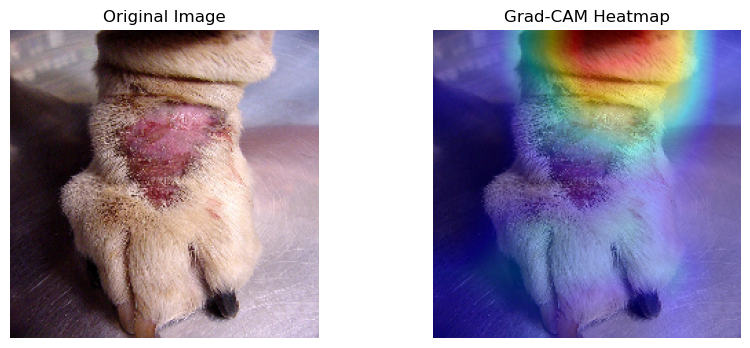

In [35]:
# Get model prediction
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions)  # Get the class index

# Generate Grad-CAM heatmap
heatmap = get_grad_cam(model, input_image, predicted_class)

# Load original image for overlay
orig_img = cv2.imread(img_path)
orig_img = cv2.resize(orig_img, (224, 224))  # Resize to match heatmap size

# Convert heatmap to color
heatmap = cv2.resize(heatmap, (224, 224))  # No need for .numpy()
  # Resize heatmap to match image
heatmap = np.uint8(255 * heatmap)  # Scale between 0-255
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply color mapping

# Overlay heatmap on original image
overlayed_img = cv2.addWeighted(orig_img, 0.6, heatmap, 0.4, 0)

# Display results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(cv2.cvtColor(overlayed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


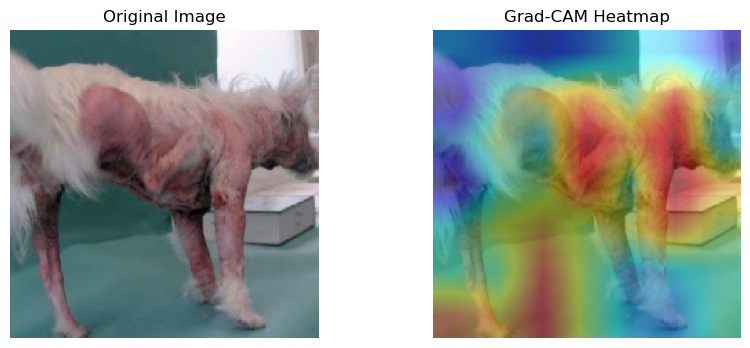

In [44]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load trained model
model = load_model(r'C:\Users\vishn\Desktop\mini project\dog_skin_disease_densenet121_finetuned_model.h5')

# Function to preprocess input image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize
    return img_array

# Load & preprocess the image
img_path = r"C:\Users\vishn\Downloads\hyper.jpg"  # Replace with your test image
input_image = preprocess_image(img_path)

# Automatically detect the last convolutional layer
last_conv_layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]

# Define Grad-CAM function
def get_grad_cam(model, img_array, class_index):
    grad_model = tf.keras.models.Model(
        [model.input], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]  # Focus on the predicted class

    grads = tape.gradient(loss, conv_outputs)  # Compute gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Global average pooling

    conv_outputs = conv_outputs[0]  # Remove batch dimension
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)  # Weighted sum of feature maps

    # Normalize heatmap for visualization
    heatmap = np.maximum(heatmap, 0)  # ReLU activation
    heatmap /= np.max(heatmap)  # Normalize between 0 and 1
    return heatmap  # FIX: No need to convert to .numpy()

# Get model prediction
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions)  # Get the class index

# Generate Grad-CAM heatmap
heatmap = get_grad_cam(model, input_image, predicted_class)

# Load original image for overlay
orig_img = cv2.imread(img_path)
orig_img = cv2.resize(orig_img, (224, 224))  # Resize to match heatmap size

# Convert heatmap to color
heatmap = cv2.resize(heatmap, (224, 224))  # No need for .numpy()
heatmap = np.uint8(255 * heatmap)  # Scale between 0-255
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply color mapping

# Overlay heatmap on original image
overlayed_img = cv2.addWeighted(orig_img, 0.6, heatmap, 0.4, 0)

# Display results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(cv2.cvtColor(overlayed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()


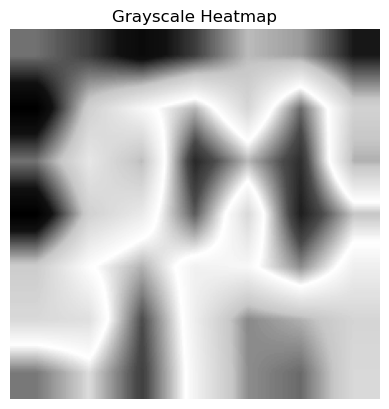

In [48]:
# Convert heatmap to grayscale
gray_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)

# Display grayscale heatmap
plt.imshow(gray_heatmap, cmap="gray")
plt.title("Grayscale Heatmap")
plt.axis("off")
plt.show()


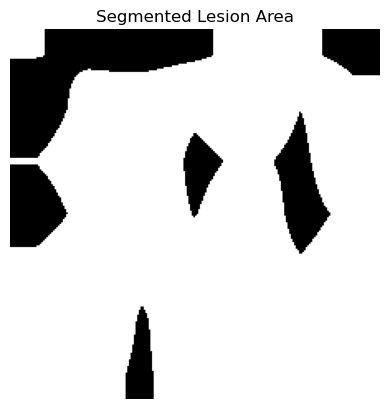

In [50]:
# Apply thresholding to segment the lesion
_, lesion_mask = cv2.threshold(gray_heatmap, 100, 255, cv2.THRESH_BINARY)

# Display lesion mask
plt.imshow(lesion_mask, cmap="gray")
plt.title("Segmented Lesion Area")
plt.axis("off")
plt.show()


In [52]:
total_pixels = 224 * 224  # Total pixels in the image
affected_pixels = np.sum(lesion_mask > 0)  # Count white pixels in lesion mask

# Compute the affected percentage
affected_percentage = (affected_pixels / total_pixels) * 100

print(f"Affected Area Percentage: {affected_percentage:.2f}%")


Affected Area Percentage: 81.68%


In [54]:
if affected_percentage > 50:
    severity = "Severe"
elif affected_percentage > 20:
    severity = "Moderate"
else:
    severity = "Mild"

print(f"Disease Severity: {severity} ({affected_percentage:.2f}% affected)")


Disease Severity: Severe (81.68% affected)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


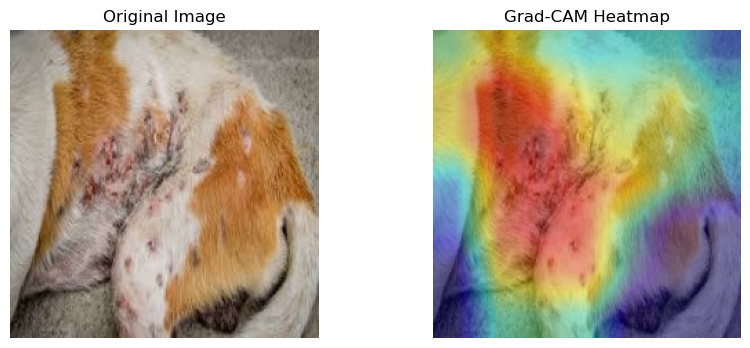

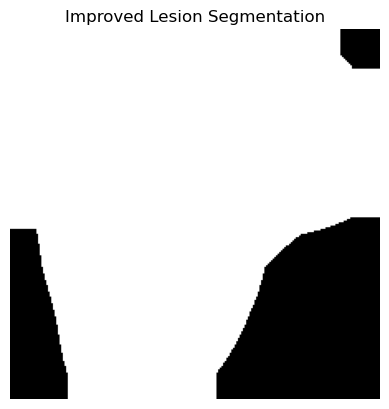

Predicted Disease: Fungal Infection
Confidence Score: 99.98%
Affected Area: 77.01%
Disease Severity: Severe


In [97]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load trained model
model = load_model(r'C:\Users\vishn\Desktop\mini project\dog_skin_disease_densenet121_finetuned_model.h5')

# Define class names for predictions
class_labels = {
    0: "Bacterial Dermatosis",
    1: "Fungal Infection",
    2: "Healthy",
    3: "Allergic Dermatosis"
}

# Function to preprocess input image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize
    return img_array

# Load & preprocess the image
img_path = r"C:\Users\vishn\Downloads\fung.jpeg"  # Replace with your test image
input_image = preprocess_image(img_path)

# Automatically detect the last convolutional layer
last_conv_layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]

# Define Grad-CAM function
def get_grad_cam(model, img_array, class_index):
    grad_model = tf.keras.models.Model(
        [model.input],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]  # Focus on the predicted class

    grads = tape.gradient(loss, conv_outputs)  # Compute gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Global average pooling

    conv_outputs = conv_outputs[0]  # Remove batch dimension
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)  # Weighted sum of feature maps

    # Normalize heatmap for visualization
    heatmap = np.maximum(heatmap, 0)  # ReLU activation
    heatmap /= np.max(heatmap)  # Normalize between 0 and 1
    return heatmap  # Return as NumPy array

# Get model prediction
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions)  # Get the class index
confidence_score = np.max(predictions) * 100  # Confidence score
predicted_disease = class_labels[predicted_class]  # Get disease name

# Generate Grad-CAM heatmap
heatmap = get_grad_cam(model, input_image, predicted_class)

# Load original image for overlay
orig_img = cv2.imread(img_path)
orig_img = cv2.resize(orig_img, (224, 224))  # Resize to match heatmap size

# Convert heatmap to color
heatmap = cv2.resize(heatmap, (224, 224))  # Resize to match image
heatmap = np.uint8(255 * heatmap)  # Scale between 0-255
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply color mapping

# Overlay heatmap on original image
overlayed_img = cv2.addWeighted(orig_img, 0.6, heatmap, 0.4, 0)

# Display Grad-CAM results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(cv2.cvtColor(overlayed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()

# Step 2: Improved Segmentation using Contour Detection

# Convert heatmap to grayscale
gray_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)

# Apply thresholding to extract the lesion area
_, lesion_mask = cv2.threshold(gray_heatmap, 100, 255, cv2.THRESH_BINARY)

# Find contours in the thresholded image
contours, _ = cv2.findContours(lesion_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter small contours (to remove noise)
min_contour_area = 500  # Adjust as needed
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

# Create an empty mask to draw the largest lesion area
contour_mask = np.zeros_like(lesion_mask)

# Draw the filtered contours on the mask
cv2.drawContours(contour_mask, filtered_contours, -1, (255), thickness=cv2.FILLED)

# Compute affected area percentage based on filtered contours
total_pixels = 224 * 224  # Total image size
affected_pixels = np.sum(contour_mask > 0)  # Count pixels inside valid contours
affected_percentage = (affected_pixels / total_pixels) * 100

# Assign severity levels based on affected area
if affected_percentage > 60:
    severity = "Severe"
elif affected_percentage > 30:
    severity = "Moderate"
else:
    severity = "Mild"

# Display the improved segmented lesion mask
plt.imshow(contour_mask, cmap="gray")
plt.title("Improved Lesion Segmentation")
plt.axis("off")
plt.show()

# Print final results
print(f"Predicted Disease: {predicted_disease}")
print(f"Confidence Score: {confidence_score:.2f}%")
print(f"Affected Area: {affected_percentage:.2f}%")
print(f"Disease Severity: {severity}")

In [83]:
#contour detection

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


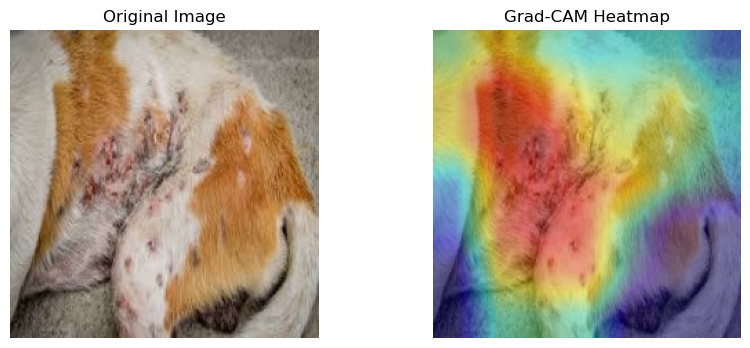

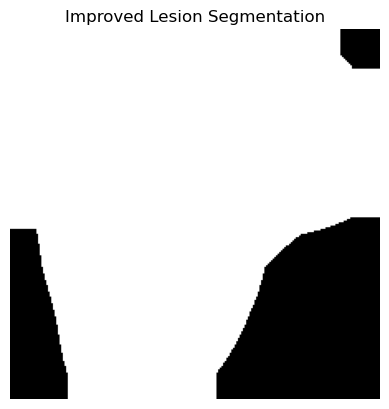

Predicted Disease: Fungal Infection
Confidence Score: 99.98%
Affected Area: 77.01%
Disease Severity: Moderate


In [103]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load trained model
model = load_model(r'C:\Users\vishn\Desktop\mini project\dog_skin_disease_densenet121_finetuned_model.h5')

# Define class names for predictions
class_labels = {
    0: "Bacterial Dermatosis",
    1: "Fungal Infection",
    2: "Healthy",
    3: "Allergic Dermatosis"
}

# Function to preprocess input image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize
    return img_array

# Load & preprocess the image
img_path = r"C:\Users\vishn\Downloads\fung.jpeg"  # Replace with your test image
input_image = preprocess_image(img_path)

# Automatically detect the last convolutional layer
last_conv_layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]

# Define Grad-CAM function
def get_grad_cam(model, img_array, class_index):
    grad_model = tf.keras.models.Model(
        [model.input], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]  # Focus on the predicted class

    grads = tape.gradient(loss, conv_outputs)  # Compute gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Global average pooling

    conv_outputs = conv_outputs[0]  # Remove batch dimension
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)  # Weighted sum of feature maps

    # Normalize heatmap for visualization
    heatmap = np.maximum(heatmap, 0)  # ReLU activation
    heatmap /= np.max(heatmap)  # Normalize between 0 and 1
    return heatmap  # Return as NumPy array

# Get model prediction
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions)  # Get the class index
confidence_score = np.max(predictions) * 100  # Confidence score
predicted_disease = class_labels[predicted_class]  # Get disease name

# Generate Grad-CAM heatmap
heatmap = get_grad_cam(model, input_image, predicted_class)

# Load original image for overlay
orig_img = cv2.imread(img_path)
orig_img = cv2.resize(orig_img, (224, 224))  # Resize to match heatmap size

# Convert heatmap to color
heatmap = cv2.resize(heatmap, (224, 224))  # Resize to match image
heatmap = np.uint8(255 * heatmap)  # Scale between 0-255
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply color mapping

# Overlay heatmap on original image
overlayed_img = cv2.addWeighted(orig_img, 0.6, heatmap, 0.4, 0)

# Display Grad-CAM results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(cv2.cvtColor(overlayed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()

# Step 2: Improved Segmentation using Contour Detection

# Convert heatmap to grayscale
gray_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)

# Apply thresholding to extract the lesion area
_, lesion_mask = cv2.threshold(gray_heatmap, 100, 255, cv2.THRESH_BINARY)

# Find contours in the thresholded image
contours, _ = cv2.findContours(lesion_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter small contours (to remove noise)
min_contour_area = 500  # Adjust as needed
filtered_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]

# Create an empty mask to draw the largest lesion area
contour_mask = np.zeros_like(lesion_mask)

# Draw the filtered contours on the mask
cv2.drawContours(contour_mask, filtered_contours, -1, (255), thickness=cv2.FILLED)

# Compute affected area percentage based on filtered contours
total_pixels = 224 * 224  # Total image size
affected_pixels = np.sum(contour_mask > 0)  # Count pixels inside valid contours
affected_percentage = (affected_pixels / total_pixels) * 100

# Assign severity levels based on affected area
if affected_percentage >705:
    severity = "Severe"
elif affected_percentage > 40:
    severity = "Moderate"
elif affected_percentage > 15:
    severity = "Mild"
else:
    severity = "Very Mild or Healthy"

# Display the improved segmented lesion mask
plt.imshow(contour_mask, cmap="gray")
plt.title("Improved Lesion Segmentation")
plt.axis("off")
plt.show()

# Print final results
print(f"Predicted Disease: {predicted_disease}")
print(f"Confidence Score: {confidence_score:.2f}%")
print(f"Affected Area: {affected_percentage:.2f}%")
print(f"Disease Severity: {severity}")


In [109]:
#new code without contour

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


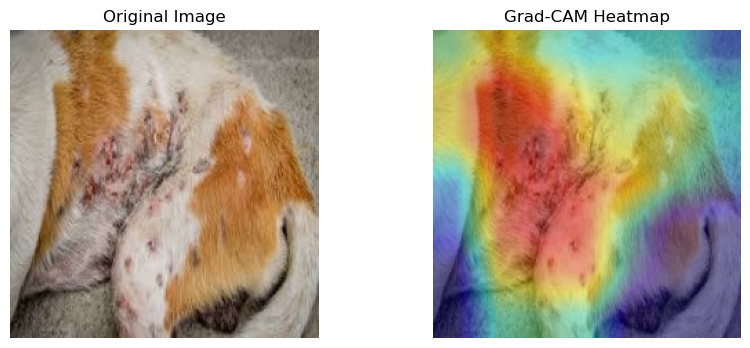

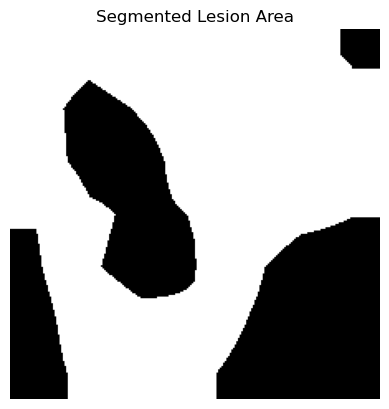

Predicted Disease: Fungal Infection
Confidence Score: 99.98%
Affected Area: 64.95%
Disease Severity: Moderate


In [111]:
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load trained model
model = load_model(r'C:\Users\vishn\Desktop\mini project\dog_skin_disease_densenet121_finetuned_model.h5')

# Define class names for predictions
class_labels = {
    0: "Bacterial Dermatosis",
    1: "Fungal Infection",
    2: "Healthy",
    3: "Allergic Dermatosis"
}

# Function to preprocess input image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))  # Resize image
    img_array = image.img_to_array(img)  # Convert to array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize
    return img_array

# Load & preprocess the image
img_path = r"C:\Users\vishn\Downloads\fung.jpeg"  # Replace with your test image
input_image = preprocess_image(img_path)

# Automatically detect the last convolutional layer
last_conv_layer_name = [layer.name for layer in model.layers if 'conv' in layer.name][-1]

# Define Grad-CAM function
def get_grad_cam(model, img_array, class_index):
    grad_model = tf.keras.models.Model(
        [model.input], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]  # Focus on the predicted class

    grads = tape.gradient(loss, conv_outputs)  # Compute gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))  # Global average pooling

    conv_outputs = conv_outputs[0]  # Remove batch dimension
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)  # Weighted sum of feature maps

    # Normalize heatmap for visualization
    heatmap = np.maximum(heatmap, 0)  # ReLU activation
    heatmap /= np.max(heatmap)  # Normalize between 0 and 1
    return heatmap  # Return as NumPy array

# Get model prediction
predictions = model.predict(input_image)
predicted_class = np.argmax(predictions)  # Get the class index
confidence_score = np.max(predictions) * 100  # Confidence score
predicted_disease = class_labels[predicted_class]  # Get disease name

# Generate Grad-CAM heatmap
heatmap = get_grad_cam(model, input_image, predicted_class)

# Load original image for overlay
orig_img = cv2.imread(img_path)
orig_img = cv2.resize(orig_img, (224, 224))  # Resize to match heatmap size

# Convert heatmap to color
heatmap = cv2.resize(heatmap, (224, 224))  # Resize to match image
heatmap = np.uint8(255 * heatmap)  # Scale between 0-255
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)  # Apply color mapping

# Overlay heatmap on original image
overlayed_img = cv2.addWeighted(orig_img, 0.6, heatmap, 0.4, 0)

# Display Grad-CAM results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Grad-CAM Heatmap")
plt.imshow(cv2.cvtColor(overlayed_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.show()

# Step 2: Simple Threshold-Based Segmentation (No Contours)

# Convert heatmap to grayscale
gray_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2GRAY)

# Apply thresholding to extract the lesion area
_, lesion_mask = cv2.threshold(gray_heatmap, 100, 255, cv2.THRESH_BINARY)

# Compute affected area percentage based on thresholding
total_pixels = 224 * 224  # Total image size
affected_pixels = np.sum(lesion_mask > 0)  # Count white pixels
affected_percentage = (affected_pixels / total_pixels) * 100

# Assign severity levels based on affected area
if affected_percentage > 65:
    severity = "Severe"
elif affected_percentage > 35:
    severity = "Moderate"
elif affected_percentage > 15:
    severity = "Mild"
else:
    severity = "Very Mild or Healthy"

# Display the segmented lesion mask
plt.imshow(lesion_mask, cmap="gray")
plt.title("Segmented Lesion Area")
plt.axis("off")
plt.show()

# Print final results
print(f"Predicted Disease: {predicted_disease}")
print(f"Confidence Score: {confidence_score:.2f}%")
print(f"Affected Area: {affected_percentage:.2f}%")
print(f"Disease Severity: {severity}")

